In [ ]:
!pip install -q imbalanced-learn sastrawi tqdm
!pip install xgboost -q
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.utils import resample
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, ArrayDictionary, StopWordRemover
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

import pandas as pd
import numpy as np
df = pd.read_csv('ulasanDPS.csv')
df

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.1 MB/s eta 0:00:00


,ulasan,rating,sentiment
0,Banyak cctv yg tidak bisa menampilkan kondisi ...,2,negatif
1,1 bintang dulu ya. Tiang sudah dari kemarin do...,1,negatif
2,Saat membuat pengaduan aplikasi tiba2 crash da...,1,negatif
3,"menu Daftar masih eror, Menu Live CCTV masih E...",2,negatif
4,"Saya sudah donlod dan gak berguna sama skali, ...",1,negatif
...,...,...,...
149,Mantap,5,positif
150,top,5,positif
151,Mantapp💪,5,positif
152,Inspirasi banget😍😍😍😍😍,5,positif


In [ ]:
def clean_text(text):
    text = re.sub(r"@[a-zA-Z0-9_]+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"https?://\S+", "", text)
    text = re.sub(r"[^a-zA-Z0-9 ]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text.lower()

df['ulasan'] = df['ulasan'].apply(clean_text)
df

,ulasan,rating,sentiment
0,banyak cctv yg tidak bisa menampilkan kondisi ...,2,negatif
1,1 bintang dulu ya tiang sudah dari kemarin dow...,1,negatif
2,saat membuat pengaduan aplikasi tiba2 crash da...,1,negatif
3,menu daftar masih eror menu live cctv masih er...,2,negatif
4,saya sudah donlod dan gak berguna sama skali m...,1,negatif
...,...,...,...
149,mantap,5,positif
150,top,5,positif
151,mantapp,5,positif
152,inspirasi banget,5,positif


In [ ]:
df_norm = df["ulasan"]
df_norm
norm = {
    " menampilkanpun " : " tampilkan ",
    " yg " : " yang ",
    " hmmm " : " miris ",
    " tiang " : " saya ",
    " dgn " : " dengan ",
    " tiba2 " : " tiba-tiba ",
    " donlod " : " download ",
    " gak " : " tidak ",
    " skali " : " sekali ",
    " slalu " : " selalu ",
    " cincong " : " omong ",
    " notif " : " notifikasi ",
    " rempong " : " ribet ",
    " useless " : " sulit ",
    " aja " : " saja ",
    " tp " : " tapi ",
    " tak " : " tidak ",
    " setengah2 " : " setengah-setengah ",
    " jd " : " jadi ",
    " kyk " : " seperti ",
    " apps " : " aplikasi ",
    " suksma " : " terimakasih ",
    " utk " : " untuk ",
    " tdk " : " tidak ",
    " krn " : " karena ",
    " mw " : " mau ",
    " pdhal " : " padahal ",
    " dn " : " dan ",
    " mncoba " : " tidak ",
    " msti " : " mesti ",
    " gmn " : " gimana ",
    " bs " : " bisa ",
    " aj " : " saja ",
    " nasbedag " : " buruk ",
    " pass " : " password ",
    " kl " : " kalau ",
    " mala " : " malah ",
    " gk " : " tidak ",
    " ngabosin " : " habisin ",
    " kouta " : " kuota ",
    " ga " : " tidak ",
    " memaksukan " : " memasukkan ",
    " poto " : " foto ",
    " req " : " request ",
    " trs " : " terus ",
    " sll " : " selalu ",
    " apk " : " aplikasi ",
    " prosea " : " proses ",
    " dpat " : " dapat ",
    " apk " : " aplikasi ",
    " ndak " : " tidak ",
    " dr " : " dari ",
    " sama2 " : " sama-sama ",
    " gak " : " tidak ",
    " paswd " : " password ",
    " nkk " : " nik ",
    " syaratnta " : " syaratnya ",
    " dg " : " dengan ",
    " dsini " : " disini ",
    " sangat2 " : " sangat-sangat ",
    " app " : " aplikasi ",
    " pnting " : " penting ",
    " lbh " : " lebih ",
    " n " : " dan ",
    " trus " : " lalu ",
    " hadehhh " : " aduh ",
    " nggk " : " tidak ",
    " paswd " : " password ",
    " naskleng " : " buruk ",
    " betula " : " betul ",
    " wktu " : " waktu ",
    " nggk " : " tidak ",
    " uka " : " buka ",
    " aing " : " tidak ",
    " nyidang " : " bisa ",
    " trosss " : " terus ",
    " mmg " : " memang ",
    " gmbar " : " gambar ",
    " apa2 " : " apa-apa ",
    " dibgian " : " dibagian ",
    " ko " : " kok ",
    " ne " : " ini ",
    " mare " : " baru ",
    " cctvya " : " cctvnya ",
    " ndak " : " tidak ",
    " aploud " : " upload ",
    " trimakasi " : " terimakasih ",
    " salute " : " salut ",
    " smkin " : " semakin ",
    " aada " : " ada ",
    " inj " : " ini ",
    " jalab " : " jalan ",
    " dll " : " dan lain-lain ",
    " ngak " : " tidak ",
    " shanti " : " tentram ",
    " astukare " : " semoga ",

}

def normalisasi(str_text):
    for i in norm:
        str_text = str_text.replace(i, norm[i])
    return str_text

df["ulasan"] = df["ulasan"].apply(normalisasi)
df

,ulasan,rating,sentiment
0,banyak cctv yang tidak bisa menampilkan kondis...,2,negatif
1,1 bintang dulu ya saya sudah dari kemarin down...,1,negatif
2,saat membuat pengaduan aplikasi tiba-tiba cras...,1,negatif
3,menu daftar masih eror menu live cctv masih er...,2,negatif
4,saya sudah download dan tidak berguna sama sek...,1,negatif
...,...,...,...
149,mantap,5,positif
150,top,5,positif
151,mantapp,5,positif
152,inspirasi banget,5,positif


In [ ]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

factory = StopWordRemoverFactory()
stop_remover = factory.create_stop_word_remover()

def remove_stopwords(text):
    return stop_remover.remove(text)

df["ulasan"] = df["ulasan"].apply(remove_stopwords)

In [ ]:
tokenized = df["ulasan"].apply(lambda x: x.split())
tokenized

,ulasan
0,"[banyak, cctv, menampilkan, kondisi, simpang, ..."
1,"[1, bintang, dulu, dari, kemarin, download, se..."
2,"[membuat, pengaduan, aplikasi, tiba-tiba, cras..."
3,"[menu, daftar, eror, menu, live, cctv, eror, m..."
4,"[sudah, download, berguna, sama, sekali, mau, ..."
...,...
149,[mantap]
150,[top]
151,[mantapp]
152,"[inspirasi, banget]"


In [ ]:
!pip install sastrawi tqdm
import pandas as pd
from tqdm import tqdm
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from tqdm.notebook import tqdm
tqdm.pandas()

stemmer = StemmerFactory().create_stemmer()

def stemming(text):
    return ' '.join([stemmer.stem(word) for word in text.split()])

df["ulasan"] = df["ulasan"].progress_apply(stemming)
df

  0%|          | 0/154 [00:00<?, ?it/s]

,ulasan,rating,sentiment
0,banyak cctv tampil kondisi simpang beberapa ta...,2,negatif
1,1 bintang dulu dari kemarin download selalu re...,1,negatif
2,buat adu aplikasi tiba crash logout tiba saat ...,1,negatif
3,menu daftar eror menu live cctv eror menu info...,2,negatif
4,sudah download guna sama sekali mau daftar sel...,1,negatif
...,...,...,...
149,mantap,5,positif
150,top,5,positif
151,mantapp,5,positif
152,inspirasi banget,5,positif


In [ ]:
df = df.dropna(subset=['sentiment'])
df = df[df['ulasan'].str.strip() != '']
teks_komentar = df[['ulasan', 'sentiment']]

In [ ]:
print("Jumlah data per kelas sentimen:")
print(df['sentiment'].value_counts())

Jumlah data per kelas sentimen:
sentiment
positif    84
negatif    64
Name: count, dtype: int64


In [ ]:
# TF-IDF
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(df['ulasan'])
y = df['sentiment']
print(X_tfidf.shape[1])

467


In [ ]:
from imblearn.over_sampling import SMOTE

smote=SMOTE(sampling_strategy='minority')
X_res, y_res = smote.fit_resample(X_tfidf, y)
y_res.value_counts()

,count
sentiment,
negatif,84
positif,84


In [ ]:
# Split dataset dari hasil SMOTE
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res,
    test_size=0.2,
    stratify=y_res,
    random_state=42
)

In [ ]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [ ]:
import xgboost as xgb
model = xgb.XGBClassifier(n_estimators= 10 )
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=10,
              n_jobs=None, num_parallel_tree=None, ...)

Akurasi Training: 0.93
Akurasi Testing: 0.85

=== Classification Report (TRAINING) ===
              precision    recall  f1-score   support

     negatif       0.95      0.90      0.92        67
     positif       0.90      0.96      0.93        67

    accuracy                           0.93       134
   macro avg       0.93      0.93      0.93       134
weighted avg       0.93      0.93      0.93       134


=== Classification Report (TESTING) ===
              precision    recall  f1-score   support

     negatif       0.83      0.88      0.86        17
     positif       0.88      0.82      0.85        17

    accuracy                           0.85        34
   macro avg       0.85      0.85      0.85        34
weighted avg       0.85      0.85      0.85        34



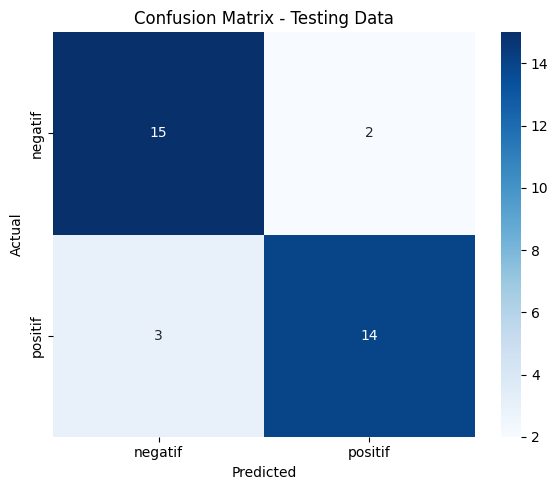

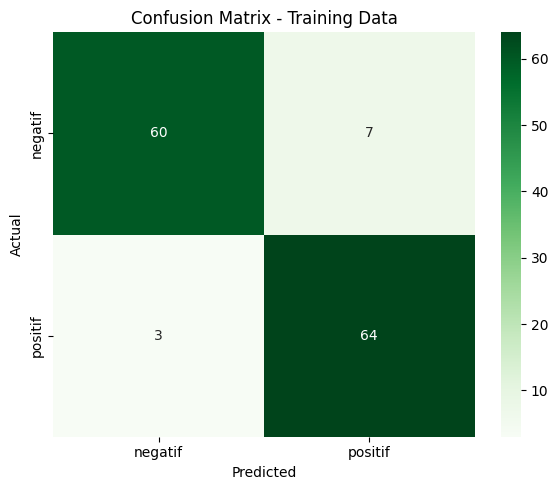

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Prediksi
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Akurasi
akurasi_train = accuracy_score(y_train, y_train_pred)
akurasi_test = accuracy_score(y_test, y_test_pred)

print(f"Akurasi Training: {akurasi_train:.2f}")
print(f"Akurasi Testing: {akurasi_test:.2f}")

# Label kelas (ambil dari LabelEncoder supaya string)
try:
    labels = le.classes_  # misalnya ['negatif', 'positif']
except:
    labels = [str(l) for l in sorted(set(y_train) | set(y_test))]

# Classification Report
print("\n=== Classification Report (TRAINING) ===")
print(classification_report(y_train, y_train_pred, target_names=labels))

print("\n=== Classification Report (TESTING) ===")
print(classification_report(y_test, y_test_pred, target_names=labels))

# Confusion Matrix - Testing
cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Testing Data')
plt.tight_layout()
plt.show()

# Confusion Matrix - Training
cm_train = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Training Data')
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

feature_names = vectorizer.get_feature_names_out()
tfidf_sum = X_train.sum(axis=0).A1

top_words_df = pd.DataFrame({
    'Kata': feature_names,
    'Skor_TFIDF': tfidf_sum
}).sort_values(by='Skor_TFIDF', ascending=False)

print(top_words_df.head(20))

           Kata  Skor_TFIDF
26     aplikasi    9.900223
40         baik    6.730393
101    denpasar    6.691665
255      mantap    6.490661
367      sangat    6.026436
244       login    6.018109
39        bagus    5.367934
253     manfaat    5.130397
431       tidak    5.090425
91       daftar    4.333396
63         bisa    4.260393
262  masyarakat    3.977873
409       susah    3.631387
42        bantu    3.341074
236       layan    3.337780
339         pro    3.328509
119       error    3.125136
274        moga    2.923943
71         buka    2.740578
249        maju    2.701976


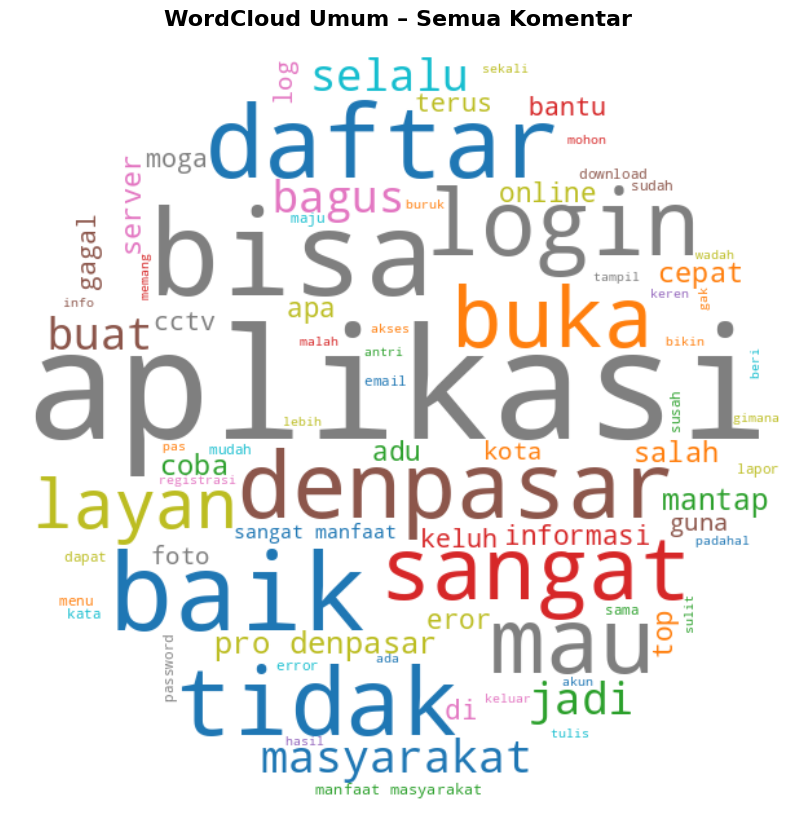

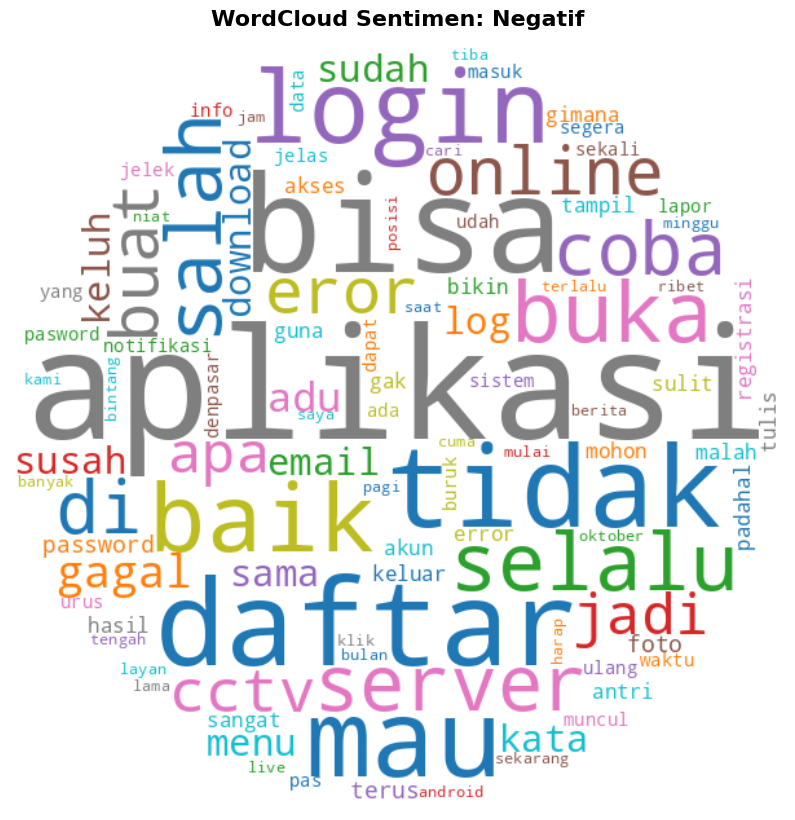

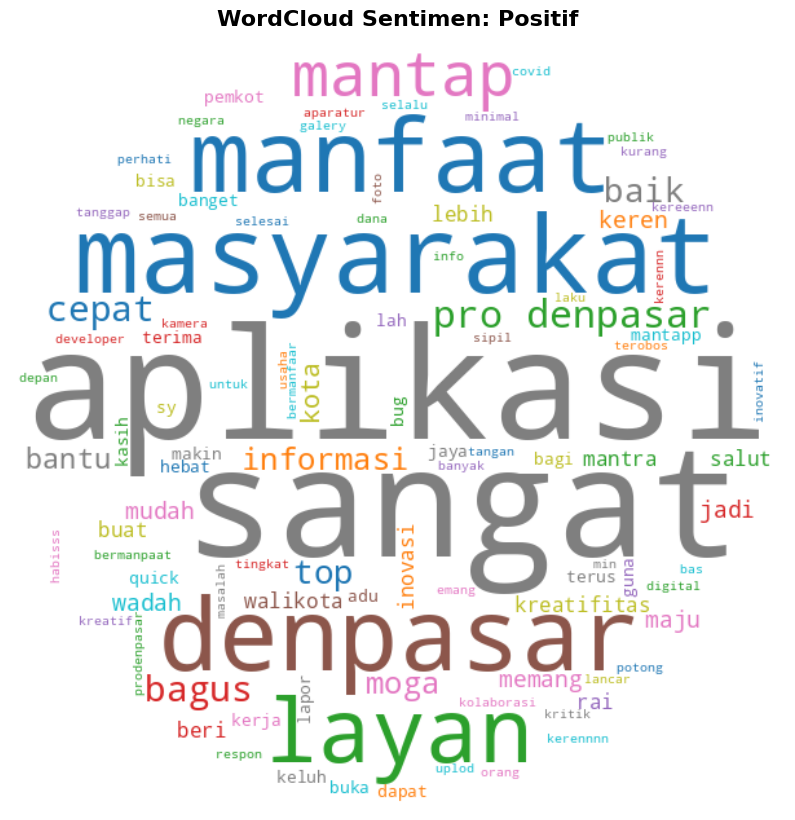

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

def create_circle_mask(diameter=600):
    """Membuat mask berbentuk lingkaran dengan ukuran diameter tertentu."""
    x, y = np.ogrid[:diameter, :diameter]
    center = diameter // 2
    radius = diameter // 2
    mask = (x - center)**2 + (y - center)**2 > radius**2
    mask = 255 * mask.astype(int)
    return mask

def generate_wordcloud(text, title):
    circle_mask = create_circle_mask(600)

    wordcloud = WordCloud(
        width=200, height=200,
        background_color='white',
        colormap='tab10',
        max_words=100,
        prefer_horizontal=0.9,
        min_font_size=10,
        max_font_size=120,
        random_state=42,
        mask=circle_mask
    ).generate(text)

    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=16, fontweight='bold')
    plt.tight_layout(pad=0)
    plt.show()

# WordCloud semua komentar (umum)
all_text = ' '.join(df['ulasan'])
generate_wordcloud(all_text, "WordCloud Umum – Semua Komentar")

# WordCloud per sentimen (positif, negatif, netral)
for label in df['sentiment'].unique():
    sentimen_text = ' '.join(df[df['sentiment'] == label]['ulasan'])
    generate_wordcloud(sentimen_text, f"WordCloud Sentimen: {label.capitalize()}")

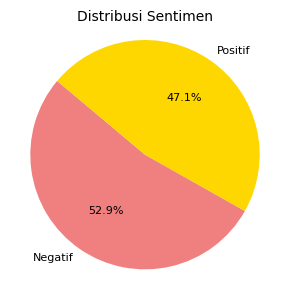

In [ ]:
label_mapping = {
    0: "Negatif",
    1: "Positif"
}

y_test_pred_nama = [label_mapping[label] for label in y_test_pred]

sentimen_count = Counter(y_test_pred_nama)

labels = list(sentimen_count.keys())
jumlah = list(sentimen_count.values())

colors = ['lightcoral', 'gold', 'mediumseagreen']

plt.figure(figsize=(3, 3))
plt.pie(
    jumlah,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    startangle=140,
    textprops={'fontsize': 8},
    radius=0.8
)
plt.title("Distribusi Sentimen", fontsize=10)
plt.axis('equal')
plt.tight_layout()
plt.show()